# A machine learning approach to extract oncogenic transcriptional profiles and to expand precision oncology

 
*The accurate identification of somatic mutations has become a pivotal component of tumor profiling and precision medicine. Yet, there is still a fraction of cancer patients without any known genomic biomarker (The ICGC/TCGA Consortium, Pan-Cancer Analysis of Whole Genomes, Nature 2020), demonstrating the need for alternative biomarkers to help clinical decision making. We reasoned that **driver mutations activating specific downstream signaling pathways are manifested as transcriptional signatures that can be leveraged to predict the potential pathogenicity and actionability of rare mutations** (Rodon et al., Genomic and Transcriptomic Profiling Expands Precision Cancer Medicine: The WINTHER Trial, Nature medicine 2019). Therefore, we developed **logistic regression classifiers** to learn the transcriptomic profiles associated with hotspot driver mutations in 16 oncogenes using data obtained from The Cancer Genome Atlas (**TCGA**) and used the classifiers to infer pathway activation status in cancers without such hotspot driver mutations. In particular, our approach incorporated the Synthetic Minority Over-sampling Technique (SMOTE) to overcome the imbalance of the input classes, as a result of the general rarity of samples with hotspot driver mutations. Our approach was first tested on the _PIK3CA_ oncogene and its E542, E545 and H1047 driver hotspot mutations leading to a mean area under receiver operator curve (ROC) score of 0.87 on a validation dataset. The same approach was then further applied to an additional 15 oncogenes, demonstrating a correlation between the sensitivity of the models and the fraction of samples with hotspot mutations in the training dataset. Finally, using the model on samples with _PIK3CA_ non-hotspot mutations and _PIK3CA_ known interactors, leading to the identification of the transcriptomic profile associated to the _PIK3CA_ hotspot driver mutations in samples with other known oncogenic mutations. Results obtained show that **transcriptomic data can be used to infer the presence of oncogenic transcriptional profiles in patients and can potentially be leveraged to help expand precision medicine**.*



### Input Data

Open access molecular data were obtained from the TCGA database. 

* Gene expression and mutation data were collected from Genome Data Commons https://gdc.cancer.gov/about-data/publications/pancanatlas. 
    * The gene expression data comprise 8184 samples across 33 cancer types and gene expression values (MapSplice + RSEM, then normalised by setting the upper-quartile to 1,000) from 20,502 genes.
    * The mutation data comprise 3.6 million mutations across 10,295 samples. 

* Cancer type and copy number alteration data were collected from the UCSC Xena https://xenabrowser.net/datapages/?cohort=TCGA%20Pan-Cancer%20(PANCAN). 
    * The copy number alteration data comprise copy number values (estimated using the GISTIC2 threshold method) for 24,776 genes across 10845 samples. 

* Information regarding the cancer and the tissue types was available for 12804 samples.



### Samples selection

Based on the presence of mutations are split into:

1) **driver hotspot** (*red*): samples with selected, known hotspot mutations in the selected oncogene; 

2) **wild-type** (*grey*): samples without non-synonymous mutations in the selected oncogene; 

3) **interactor-mutant** (*purple*): samples with any genetic alterations in any of the interactors of the selected oncogene, whose alterations can potentially confound the training of the classifier ; 

4) **non-hotspot** (*blue*): samples with non hotspot mutations in the selected oncogene. 


### Features selection
A T-test is performed between the expression of genes observed in the **driver hotspot** samples and in the **wild-type** samples. The _X_ most differentially expressed genes are used as features

### Output Data

The classifier is trained and cross validated on the training data, then tested on the testing data.

Next, the classifier is used on the **interactor-mutant** and the **non-hotspot** samples, as a _discovery_ subset, to infer the presence of the gene expression profile associated to the **driver hotspot** mutations.

A table comprising the list of alterations found in the discovery subset, the name of the relative sample, the classification infered by the model and other info.

In [ ]:
import pandas as pd
#import csv
import random
import numpy as np
import itertools
import matplotlib.pyplot as pyplot
from scipy.stats import ttest_ind
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import warnings


###############################################
########### Download and adapt data from TCGA
###############################################


rnaseq_full_df = pd.read_table("/path/to/EBPlusPlusAdjustPANCAN_IlluminaHiSeq_RNASeqV2.geneExp.tsv", index_col=0)
rnaseq_full_df.columns=list(map(lambda x: x[0:15],rnaseq_full_df.columns)) 
rnaseq_full_df=rnaseq_full_df.transpose()
rnaseq_full_df.columns= list(map(lambda x: x.split('|', 1)[0],rnaseq_full_df.columns)) 
rnaseq_full_df=rnaseq_full_df.drop(['?'], axis=1)
rnaseq_full_df=rnaseq_full_df.dropna(axis='rows')
rnaseq_full_df = rnaseq_full_df[~rnaseq_full_df.index.duplicated(keep='first')]

sample_freeze = pd.read_table("/path/to/TCGA_phenotype_denseDataOnlyDownload.tsv")
ann_mut = pd.read_table("/path/to/mc3.v0.2.8.PUBLIC.maf")
ann_mut1 = ann_mut[["Tumor_Sample_Barcode", "Hugo_Symbol", "Chromosome", "Start_Position", "End_Position", "Variant_Classification",
"Variant_Type", "Reference_Allele", "Tumor_Seq_Allele1", "Tumor_Seq_Allele2", "HGVSc", "HGVSp_Short",
"Protein_position"]]
columns = ["sample", "gene", "chr", "start", "end", "effect", "type", "ref", "alt1", "alt2", "cc", "aa", "loc"]
ann_mut1.columns= columns
ann_mut1['sample']=list(map(lambda x: x[0:15], ann_mut1['sample'])) 
ann_mut2=ann_mut1.join(sample_freeze.set_index('sample'), on='sample')
ann_mut2.drop_duplicates(inplace=True)


gistic = pd.read_table("/path/to/Gistic2_CopyNumber_Gistic2_all_thresholded.by_genes", index_col=0)
gistic=gistic.transpose()

In [2]:
###############################################
########### Main Function.
########### Needed to prepare training, testing
########### and discovery datasets.
###############################################


def Training(itn, seedn, gene, hs, lismut, ctype, smo, thr, plots):
    warnings.filterwarnings("ignore")

    if seedn == None: seedn= random.randint(1,10000)
    random.seed(seedn)
    np.random.seed(seedn)

    ###############################################
    ########### Classes selection.
    ###############################################

    cnv_purple=[]
    for i in range(len(lismut)):
        cnv_purple.append(list(set(gistic.loc[gistic[lismut[i]]==-2.0 ].index)))
        cnv_purple.append(list(set(gistic.loc[gistic[lismut[i]]==2.0 ].index)))
    cnv_purple = list(itertools.chain.from_iterable(cnv_purple))    
    purple=list(set(ann_mut2.loc[(ann_mut2['gene'].isin(lismut) | ann_mut2['sample'].isin(cnv_purple))]['sample']))

    red=list(set(ann_mut2.loc[(ann_mut2['gene'].isin(gene))  & 
                             (ann_mut2['aa'].isin(hs)) & (~ann_mut2['sample'].isin(purple))]['sample']))


    blue=list(set(ann_mut2.loc[(ann_mut2['gene'].isin(gene))  & (~ann_mut2['sample'].isin(red)) &
                             (~ann_mut2['aa'].isin(hs))& (~ann_mut2['sample'].isin(purple))]['sample']))


    grey=list(set(ann_mut2.loc[(~ann_mut2['sample'].isin(red)) & (~ann_mut2['sample'].isin(purple)) &
                               (~ann_mut2['sample'].isin(blue))]['sample']))


    whole_red_gs = rnaseq_full_df.loc[red].dropna()
    whole_grey_gs = rnaseq_full_df.loc[grey].dropna()

    whole_red_gs.sort_index(inplace=True)
    whole_grey_gs.sort_index(inplace=True)

    
    
    ###############################################
    ########### Train and test subsets split.
    ###############################################
    
    N=len(whole_red_gs)
    K=int(66*len(whole_red_gs)/100)    
    red_msk = np.array([False] * K + [True] * (N-K))
    red_train_names = whole_red_gs[red_msk]
    red_test_names = whole_red_gs[~red_msk]

    N=len(whole_grey_gs)
    K=int(66*len(whole_grey_gs)/100)
    grey_msk = np.array([False] * K + [True] * (N-K))    
    grey_train_names = whole_grey_gs[grey_msk]
    grey_test_names = whole_grey_gs[~grey_msk]

    train_names = red_train_names.append(grey_train_names , ignore_index=False)
    test_names = red_test_names.append(grey_test_names , ignore_index=False)


    clas=[0] * len(train_names)
    i=0


    for index, row in train_names.iterrows():
        x=index
        if x in grey: clas[i]=0
        elif x in red: clas[i]=1
        elif x in purple: clas[i]=2
        elif x in blue: clas[i]=3
        i=i+1

        
        
        
    ###############################################
    ########### Features selection
    ########### based on differential expressions.
    ###############################################        
        
    indWT = [i for i, x in enumerate(clas) if x == 0]
    indMU = [i-1 for i, x in enumerate(clas) if x == 1]

    tt=ttest_ind(train_names.iloc[indWT], train_names.iloc[indMU])

    mu = train_names.transpose()
    mu = mu.assign(pvalue=pd.Series(tt[1]).values)
    mu = mu.sort_values('pvalue') 
    mu=mu.head(itn)
    top_genes= mu.index


    ###############################################
    ########### Features selection
    ########### based on differential expressions.
    ############################################### 

    fitted_scaler = StandardScaler().fit(rnaseq_full_df)

    x_df_update = pd.DataFrame(fitted_scaler.transform(rnaseq_full_df),
                                columns=rnaseq_full_df.columns)
    x_df_update.index = rnaseq_full_df.index

    
    
    ###############################################
    ########### Cancer type are
    ########### added as further features.
    ############################################### 

    diseases = list(set(sample_freeze["_primary_disease"].tolist()))
    genes_types= list(top_genes) + diseases
    dissamp = list(set(sample_freeze["sample"].tolist()))
    dis10 = pd.DataFrame(0, index=dissamp, columns=diseases)

    for index, row in sample_freeze.iterrows():
        dis10.xs(row["sample"])[row["_primary_disease"]]=1

    rna_dis = x_df_update.merge(dis10, left_index=True, right_index=True)


    red_gs = rna_dis.loc[red].dropna()
    grey_gs = rna_dis.loc[grey].dropna()
    blue_gs = rna_dis.loc[blue].dropna()
    purple_gs = rna_dis.loc[purple].dropna()

    ###############################################
    ########### If a subset of cancer types
    ########### was defined, only samples from
    ########### patients with those types
    ########### are selected.
    ############################################### 
    
    dis_low=[]
    if ctype != None:
        dis_low= list(set(sample_freeze["_primary_disease"].tolist()))
        for i in ctype:
            if i in dis_low:
                dis_low.remove(i)
            else:
                print(''.join(i) + " not a cancer types")
                
    red_gs2 = red_gs[(red_gs[dis_low] != 1).all(axis=1)]
    grey_gs2 = grey_gs[(grey_gs[dis_low] != 1).all(axis=1)]
    blue_gs2 = blue_gs[(blue_gs[dis_low] != 1).all(axis=1)]
    purple_gs2 = purple_gs[(purple_gs[dis_low] != 1).all(axis=1)]

    print("Cancer types kept: " + str(list(set(diseases) - set(dis_low))))

    
    
    ###############################################
    ########### Preparation of the training and
    ########### testing matrix. 
    ############################################### 
    
    dataset_gs = red_gs2.append(grey_gs2 , ignore_index=False)
    dataset_gs.sort_index(inplace=True)

    train= dataset_gs.drop(list(set(dataset_gs.index).intersection(test_names.index)))
    test= dataset_gs.drop(list(set(dataset_gs.index).intersection(train_names.index)))

    kcol= [col for col in train.columns if col in genes_types]
    train=train[kcol]
    test=test[kcol]

    clastr=[0] * len(train)
    i=0

    for index, row in train.iterrows():
        x=index
        if x in grey: clastr[i]=0
        elif x in red: clastr[i]=1
        i=i+1

    claste=[0] * len(test)
    i=0

    for index, row in test.iterrows():
        x=index
        if x in grey: claste[i]=0
        elif x in red: claste[i]=1
        i=i+1

    ###############################################
    ########### Info.
    ###############################################        
        
    print("Classes")
    print("Hotspot mutated: " + str(len(red_gs2)))
    print("Wild-type: " + str(len(grey_gs2)))    
    print("Interactor mutated: " + str(len(purple_gs2)))
    print("Non-hotspot: " + str(len(blue_gs2))) 
    
    print("Hotspot mutated in the training subset: " + str(clastr.count(1)))
    print("Hotspot mutated in the testing subset: " + str(claste.count(1)))

    ###############################################
    ########### Functions.
    ############################################### 
    
    if plots==True: PiePlot(len(red_gs2), len(grey_gs2), len(purple_gs2), len(blue_gs2)) 
        
    model=ModelBuilding(train, clastr, test, claste, itn, ctype, seedn, gene, smo, thr, plots)
    return(Prediction(blue_gs2, purple_gs2, model, kcol, seedn, thr))


In [3]:
###############################################
########### Model training function.
###############################################


def ModelBuilding(train, clastr, test, claste, itn, ctype, seedn, gene, smo, thr, plots):   
    warnings.filterwarnings("ignore")

    ###############################################
    ########### Training data preparation.
    ###############################################
    
    dataset_array = train.values
    get=dataset_array[:, :-1]
    target=clastr

    
    ###############################################
    ########### Classifier definition.
    ###############################################    
    
    alphas=[0.2,0.5,0.8,0.1,0.13,0.15,0.18,0.2,0.25,0.3,0.5,0.8]
    l1_ratios=[0.2,0.8,0.1,0.15,0.155,0.16,0.2,0.25,0.3,0.4,0.5,0.8]

    clf_parameters = {'classify__loss': ['log'],
                        'classify__penalty': ['elasticnet'],
                        'classify__alpha': alphas, 'classify__l1_ratio': l1_ratios}

    pipe = Pipeline(steps=[('classify', SGDClassifier(random_state=seedn,
                                                        class_weight='balanced',
                                                            loss='log',
                                                            shuffle=True,  
                                                            max_iter=50,
                                                            tol=None))])

    cv_pipeline = GridSearchCV(estimator=pipe, param_grid=clf_parameters,
                                n_jobs=-1, cv=5, scoring='roc_auc',
                                return_train_score=True)

    
    
    ###############################################
    ########### Classifier training.
    ########### If selected, SMOTE balances
    ########### input samples.
    ###############################################

    if smo==True:
        sm = SMOTE(random_state=seedn)
        smo_txt="SMOTE"
        try:
            get, target = sm.fit_resample(get, target)
        except ValueError:
            return()
        model = cv_pipeline.fit(get, target) #, model__sample_weight= cibval.tolist())
    elif smo==False:
        model = cv_pipeline.fit(get, target)
        smo_txt="No_SMOTE"


    ###############################################
    ########### Training subset accuracy scores.
    ########### If defined, a treshold value is used.
    ###############################################        
        
    THRESHOLD=thr
    targg=(model.predict_proba(get[:, :])[:,1] >= THRESHOLD).astype(bool)
    
    CM=confusion_matrix(target, targg)
    a=float(CM[1][1]/(CM[1][1]+CM[1][0]))
    b= float(CM[0][0]/(CM[0][0]+CM[0][1]))
    c= accuracy_score(target, targg)  

    cv=cross_val_score(model, get, target, cv=5, scoring='accuracy')

    dataset_array = train.values
    gettr=dataset_array[:, :-1]
    target=clastr

    probstr = model.predict_proba(gettr[:, :])
    probstr = probstr[:, 1]


    try:
        d=roc_auc_score(clastr, probstr) 
    except ValueError:
        return(print(''.join(gene) + " doen't have enough samples to be processed"))

    ###############################################
    ########### Training data preparation
    ########### and prediction.
    ###############################################
    
    dataset_array = test.values
    get=dataset_array[:, :-1]
    target=claste

    THRESHOLD=thr
    targg=(model.predict_proba(get[:, :])[:,1] >= THRESHOLD).astype(bool)
    

    ###############################################
    ########### Testing subset accuracy scores.
    ########### If defined, a treshold value is used.
    ############################################### 
    
    CM=confusion_matrix(target, targg)

    h= float(CM[1][1]/(CM[1][1]+CM[1][0]))   

    i= float(CM[0][0]/(CM[0][0]+CM[0][1]))

    l= accuracy_score(target, targg) 


    dataset_array = test.values
    gette=dataset_array[:, :-1]
    target=claste
    probste = model.predict_proba(gette[:, :])
    probste = probste[:, 1]

    try: 
        m=roc_auc_score(claste, probste)    
    except ValueError:
        return(print(''.join(gene) + " doen't have enough samples to be processed"))

    ###############################################
    ########### Info.
    ############################################### 
    
    print("\n")
    print("Number of samples in the training subset: " + str(len(train)))
    print("Number of samples in the testing subset: " + str(len(test)))
    print("Seed " + str(seedn)  + "CV " + str(cv)) 
    print("Training")
    print("Sensitivity: " + str(a) + ", Specificity: " + str(b) + ", Accuracy: " + str(c) +", ROC score: "+ str(d))
    print("Cross Validation score: " + str(cv))
    print("Testing")
    print("Sensitivity: " + str(h) + ", Specificity: " + str(i) + ", Accuracy: " + str(l) +", ROC score:" + str(m))
    print("Gene: " + str(gene) + ", # genes in the profile: " + str(itn))    

    
    ###############################################
    ########### If plots were selected,
    ########### the ROC plot is generated.
    ############################################### 
    if plots==True: ROCplot(train, clastr, test, claste, itn, ctype, smo_txt, seedn, model, gene) 

    return(model)



In [4]:
###############################################
########### ROC curve plot.
###############################################

def ROCplot(train, clastr, test, claste, itn, ctype, smot, seedn, model, gene):
    
    fig1 = pyplot.gcf()

    dataset_array = train.values
    gettr=dataset_array[:, :-1]
    target=clastr
    dataset_array = test.values
    gette=dataset_array[:, :-1]
    target=claste

    probstr = model.predict_proba(gettr[:, :])
    probstr = probstr[:, 1]
    aucttr = roc_auc_score(clastr, probstr)
    probste = model.predict_proba(gette[:, :])
    probste = probste[:, 1]
    aucte = roc_auc_score(claste, probste)
    print('Training set AUC: %.3f' % aucttr)
    fprte, tprte, thresholdste = roc_curve(claste, probste)
    print('Validation set AUC: %.3f' % aucte )
    fprtr, tprtr, thresholdstr = roc_curve(clastr, probstr)

    pyplot.grid(color='w', linestyle='solid', lw=2)
    pyplot.plot([0, 1], [0, 1], linestyle='--', lw=2)
    pyplot.plot(fprtr, tprtr, marker='.', label='train ROC curve (area = %0.2f)' % aucttr)
    pyplot.plot([0, 1], [0, 1], linestyle='--', color='darkorange', lw=2)
    pyplot.plot(fprte, tprte, marker='.', label='test ROC curve (area = %0.2f)' % aucte)

    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    if ctype == None: 
        pyplot.title(''.join(gene)  + ' + ' +str(itn) +' + PanCancer + ' + str(smot))
    else:
        pyplot.title(''.join(gene)  + ' + ' +str(itn) +' + ' + ', '.join(ctype) + ' + ' + str(smot))
    pyplot.legend(loc="lower right")

    pyplot.xlim([0.0, 1.0])
    pyplot.ylim([0.0, 1.05])

    pyplot.show()
    pyplot.draw()


#    if ctype == None: 
#        fig1.savefig("/Users/andrea/Documents/BI/BI/B/PhD/articolo/" + ''.join(gene)  + '_' + str(itn) +'_PanCancer_' + str(smot) + '_'+ str(seedn) +".pdf", dpi=100)
#    else:
#        fig1.savefig("/Users/andrea/Documents/BI/BI/B/PhD/articolo/" + ''.join(gene)  + '_' + str(itn) +'_' + ', '.join(ctype) + '_' + str(smot) + '_'+ str(seedn) +".pdf", dpi=100)
    pyplot.close()



In [5]:
###############################################
########### Pie plot showing classes distributions.
###############################################

def PiePlot(red_size, grey_size, purple_size, blue_size):
    labels = 'Red', 'Grey', 'Purple', 'Blue'
    sizes = [red_size, grey_size, purple_size, blue_size]
    colors = ['red', 'silver', 'mediumorchid', 'cornflowerblue']
    explode = (0.2, 0, 0, 0)  # explode 1st slice

    ax=pyplot.pie(sizes, explode=explode,  colors=colors,
    autopct='%1.1f%%', shadow=False, startangle=140)
    pyplot.axis('equal')
    pyplot.legend(ax, labels, loc="center left")
    pyplot.show()
    pyplot.draw()    
    #ax[2][0].figure.savefig('/Users/andrea/Documents/BI/BI/B/PhD/articolo/pie' + ''.join(gene) + '.pdf', format='pdf')
    

In [6]:
###############################################
########### Predictions on the non-hotspot
########### and the interactors-mutant samples
###############################################

def Prediction(blue_gs2, purple_gs2, model, kcol, seedn, thr):    

    ###############################################
    ########### Discovery matrix preparation.
    ############################################### 
    
    blue_filt0=blue_gs2[kcol]    
    purple_filt0=purple_gs2[kcol]    
    blue_filt = blue_filt0.append(purple_filt0 , ignore_index=False)    
    dataset_array_blue = blue_filt.values
    get_blue=dataset_array_blue[:, :-1]

    
    ###############################################
    ########### Prediction on the discovery samples.
    ############################################### 
    
    THRESHOLD=thr    
    targg_blue=(model.predict_proba(get_blue[:, :])[:,1] >= THRESHOLD).astype(bool)

    
    ###############################################
    ########### Samples info extraction
    ############################################### 
    
    one_blue = [i for i, x in enumerate(targg_blue) if x == 1]
    one_blue_list=list(blue_filt.index[one_blue])
    zero_blue = [i for i, x in enumerate(targg_blue) if x == 0]
    zero_blue_list=list(blue_filt.index[zero_blue])
    
    mut_set = ann_mut2.merge(sample_freeze, left_on='sample', right_on='sample')

    blue_find_one=mut_set.loc[(mut_set['sample'].str.slice(0, 15).isin(one_blue_list)) ]#& (mut_set['gene'].isin(gene))]
    blue_find_one['Prediction']="Pathway_activation"
    blue_find_one['seed']=seedn    
    blue_find_zero=mut_set.loc[(mut_set['sample'].str.slice(0, 15).isin(zero_blue_list)) ]#& (mut_set['gene'].isin(gene))]
    blue_find_zero['Prediction']="No_pathway_activation"
    blue_find_zero['seed']=seedn  
    blue_find_all = blue_find_one.append(blue_find_zero , ignore_index=False)

    return(blue_find_all)

Cancer types kept: ['KIRP', 'GBM', 'UVM', 'MESO', 'LUAD', 'PCPG', 'CESC', 'THCA', 'SKCM', 'THYM', 'ESCA', 'KICH', 'PRAD', 'LAML', 'TGCT', 'COAD', 'LIHC', 'BLCA', 'STAD', 'HNSC', 'CHOL', 'ACC', 'DLBCL', 'SARC', 'LGG', 'UCEC', 'CCSK', 'LUSC', 'UCS', 'PAAD', 'BRCA', 'OV', 'READ']
Classes
Hotspot mutated: 426
Wild-type: 5343
Interactor mutated: 2125
Non-hotspot: 290
Hotspot mutated in the training subset: 145
Hotspot mutated in the testing subset: 281


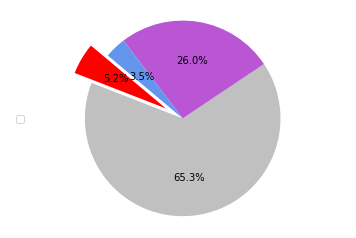



Number of samples in the training subset: 1962
Number of samples in the testing subset: 3807
Seed 3492CV [0.85714286 0.87225275 0.86088154 0.89669421 0.89944904]
Training
Sensitivity: 0.82168409466153, Specificity: 0.9515685195376995, Accuracy: 0.8866263070996148, ROC score: 0.9565824682595411
Cross Validation score: [0.85714286 0.87225275 0.86088154 0.89669421 0.89944904]
Testing
Sensitivity: 0.7829181494661922, Specificity: 0.8201928530913216, Accuracy: 0.8174415550302075, ROC score:0.8697938849784923
Gene: ['PIK3CA'], # genes in the profile: 1000
Training set AUC: 0.957
Validation set AUC: 0.870


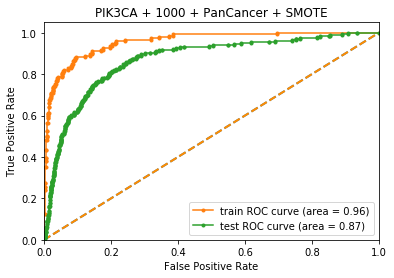

In [7]:
###############################################
########### PIK3CA example
###############################################

gene=["PIK3CA"]
hs=["p.E542K", "p.E545K", "p.H1047L", "p.H1047R"]
lismut=["PIK3R1", "PIK3R3", "HRAS", "NRAS", "MRAS", "KRAS", "PIK3R2", "ERAS", "RRAS2", "RRAS"]
ctype=None

seedn=3492


###############################################
########### Arguments: number of genes for the features selection,
########### Seed ("None" if you don't want any seed),
########### Gene name, list of driver mutations,
########### List of interactors (retrieved from StringDB),
########### Cancer types (if you want to use a specific subset, "None" for the TCGA pan-cancer data),
########### SMOTE input data adjustement ("True" if you want to balance input samples),
########### Logistic regression threshold (0.5 if you want the standard threshold value),
########### Plots ("True" if you want the script to show the pie plot and the ROC plot)
###############################################


oncogenic_samples=Training(1000, seedn, gene, hs, lismut, ctype, True, 0.7, True)

In [8]:
oncogenic_samples

,sample,gene,chr,start,end,effect,type,ref,alt1,alt2,...,aa,loc,sample_type_id_x,sample_type_x,_primary_disease_x,sample_type_id_y,sample_type_y,_primary_disease_y,Prediction,seed
99368,TCGA-18-3407-01,C10orf32,10,104620269,104620269,Missense_Mutation,SNP,G,G,T,...,p.M73I,73,1.0,Primary Tumor,LUSC,1,Primary Tumor,LUSC,Pathway_activation,3492
99369,TCGA-18-3407-01,GLRX3,10,131964943,131964943,Missense_Mutation,SNP,G,G,T,...,p.K217N,217,1.0,Primary Tumor,LUSC,1,Primary Tumor,LUSC,Pathway_activation,3492
99370,TCGA-18-3407-01,SYT15,10,46962101,46962101,Missense_Mutation,SNP,G,G,T,...,p.L379M,379,1.0,Primary Tumor,LUSC,1,Primary Tumor,LUSC,Pathway_activation,3492
99371,TCGA-18-3407-01,PPP3CB,10,75214170,75214170,Missense_Mutation,SNP,C,C,A,...,p.V396L,396,1.0,Primary Tumor,LUSC,1,Primary Tumor,LUSC,Pathway_activation,3492
99372,TCGA-18-3407-01,CYP2C18,10,96443545,96443545,5'UTR,SNP,C,C,G,...,.,.,1.0,Primary Tumor,LUSC,1,Primary Tumor,LUSC,Pathway_activation,3492
99373,TCGA-18-3407-01,CYP2C8,10,96827270,96827270,Intron,SNP,A,A,T,...,.,.,1.0,Primary Tumor,LUSC,1,Primary Tumor,LUSC,Pathway_activation,3492
99374,TCGA-18-3407-01,RDX,11,110135504,110135504,Missense_Mutation,SNP,C,C,A,...,p.K64N,64,1.0,Primary Tumor,LUSC,1,Primary Tumor,LUSC,Pathway_activation,3492
99375,TCGA-18-3407-01,C11orf57,11,111948944,111948944,Missense_Mutation,SNP,G,G,T,...,p.Q25H,25,1.0,Primary Tumor,LUSC,1,Primary Tumor,LUSC,Pathway_activation,3492
99376,TCGA-18-3407-01,VPS11,11,118952370,118952370,3'UTR,SNP,C,C,A,...,.,.,1.0,Primary Tumor,LUSC,1,Primary Tumor,LUSC,Pathway_activation,3492
99377,TCGA-18-3407-01,MICAL2,11,12245047,12245047,Missense_Mutation,SNP,G,G,T,...,p.K513N,513,1.0,Primary Tumor,LUSC,1,Primary Tumor,LUSC,Pathway_activation,3492
